<a href="https://colab.research.google.com/github/psmouli14/final_project/blob/main/few_shot_learning_with_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cifar-100-python.tar.gz to cifar-100-python.tar.gz


In [ ]:
!tar -zxvf cifar-100-python.tar.gz

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [ ]:
meta = unpickle('cifar-100-python/meta')
train = unpickle('cifar-100-python/train')
test = unpickle('cifar-100-python/test')

In [ ]:
meta_keys = list(meta.keys())
meta_keys

[b'fine_label_names', b'coarse_label_names']

In [ ]:
Classes = pd.DataFrame(meta[b'fine_label_names'],columns = ['Classes'])

In [ ]:
len(Classes)

100

In [ ]:
training_keys = list(train.keys())
training_keys

[b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']

In [ ]:
test_keys = list(test.keys())
test_keys

[b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']

In [ ]:
train_images = train[b'data']
test_images = test[b'data']
train_images.shape


(50000, 3072)

In [ ]:
test_images.shape

(10000, 3072)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
train_images = train_images.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
train_images = tf.cast(train_images, tf.float32)
train_images.shape
train_images = train_images/255

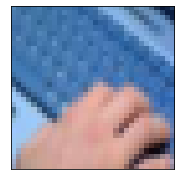

In [ ]:
plt.figure(figsize=(6,3))
plt.xticks([])
plt.yticks([])
plt.imshow(train_images[10])

In [ ]:
test_images = test_images.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
test_images = tf.cast(test_images, tf.float32)
test_images.shape
test_images = test_images/255

In [ ]:
# Now we build the labels and images as lists
train_labels = train[b'fine_labels']
test_labels = test[b'fine_labels']

In [ ]:
len(train_labels), len(test_labels)

(50000, 10000)

In [ ]:
# Lists to hold values for N-way k-shots experiments
train_num_ways = [60, 30]
test_num_ways = [5, 5]
num_shots = [5, 1]
img_width = 32
img_height = 32
channels = 3
learning_rate = 0.001
num_classes = 100

In [ ]:
print(test_images.shape)
print(train_images.shape)

(10000, 32, 32, 3)
(50000, 32, 32, 3)


In [ ]:
#split train into train and val
train_images_split = np.zeros([40000, img_width , img_height, channels], dtype=np.float32)
val_images_split = np.zeros([10000, img_width , img_height, channels], dtype=np.float32)
train_labels_split = np.zeros(40000)
val_labels_split = np.zeros(10000)

train_split = 400
val_split = 100
for class_ in range(len(Classes)):
  train_start_index = class_ * 500
  train_end_index = train_start_index + train_split
  train_index = class_ * train_split
  val_start_index = train_end_index
  val_end_index = val_start_index + val_split
  val_index = class_ * val_split

  train_images_split[train_index : train_index + train_split] = train_images[train_start_index: train_end_index]
  val_images_split[val_index : val_index + val_split] = train_images[val_start_index : val_end_index]


  train_labels_split[train_index : train_index + train_split] = train_labels[train_start_index : train_end_index]
  val_labels_split[val_index : val_index + val_split] = train_labels[val_start_index : val_end_index]


In [ ]:
print(test_images.shape)
print(train_images_split.shape)
print(val_images_split.shape)

(10000, 32, 32, 3)
(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
def get_next_batch(dataset, labels, num_way, num_shot, num_query, no_of_classes):
  episodic_classes = np.random.permutation(no_of_classes)[:num_way]
  support = np.zeros([num_way, num_shot, img_width , img_height, channels], dtype=np.float32)
  query = np.zeros([num_way, num_query, img_width , img_height, channels], dtype=np.float32)

  for index, class_ in enumerate(episodic_classes):
    indices = find_indices(labels, class_)
    #check that the size is greater than num_shot + num_query
    selected = np.random.permutation(indices)[:num_shot + num_query]
    for support_index in range(num_shot):
       support[index][support_index] = dataset[selected[support_index]] 
    for query_index in range(num_query):
       query[index][query_index] = dataset[selected[num_shot + query_index]]  
    
  return support, query

def find_indices(list_to_check, item_to_find):
  indices = []
  for idx, value in enumerate(list_to_check):
    if value == item_to_find:
      indices.append(idx)
  return indices



In [ ]:
support, query = get_next_batch(val_images_split, val_labels_split, 20, 7, 3, 100)

In [ ]:
support.shape

(20, 7, 32, 32, 3)

In [ ]:
query.shape

(20, 3, 32, 32, 3)

In [ ]:
def show_image(dataset, index, image_number):
  plt.figure(figsize=(2,3))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(dataset[index][image_number])


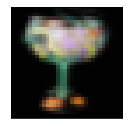

In [ ]:
show_image(support, 4, 6)

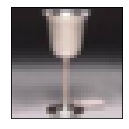

In [ ]:
show_image(query, 4, 0)

In [ ]:
from tensorflow import keras  
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras import Model

class Prototypical(Model):
    
    def __init__(self, n_support, n_query, w, h, c):
        super(Prototypical, self).__init__()
        self.w, self.h, self.c = w, h, c

        # Encoder CNN with 4 blocks
        self.encoder = keras.Sequential([
            keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPool2D((2, 2)),

            keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPool2D((2, 2)),

            keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPool2D((2, 2)),

            keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPool2D((2, 2)), Flatten()]
        )

    def call(self, support, query):
        n_class = support.shape[0]
        n_support = support.shape[1]
        n_query = query.shape[1]
        y = np.tile(np.arange(n_class)[:, np.newaxis], (1, n_query))
        y_onehot = tf.cast(tf.one_hot(y, n_class), tf.float32)

        # correct indices of support samples (just natural order)
        target_inds = tf.reshape(tf.range(n_class), [n_class, 1])
        target_inds = tf.tile(target_inds, [1, n_query])

        # merge support and query to forward through encoder
        cat = tf.concat([
            tf.reshape(support, [n_class * n_support,
                                 self.w, self.h, self.c]),
            tf.reshape(query, [n_class * n_query,
                               self.w, self.h, self.c])], axis=0)
        z = self.encoder(cat)

        # Divide embedding into support and query
        z_prototypes = tf.reshape(z[:n_class * n_support],
                                  [n_class, n_support, z.shape[-1]])
        # Prototypes are means of n_support examples
        z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)
        z_query = z[n_class * n_support:]

        # Calculate distances between query and prototypes
        dists = euclidean_distance(z_query, z_prototypes)

        # log softmax of calculated distances
        log_p_y = tf.nn.log_softmax(-dists, axis=-1)
        log_p_y = tf.reshape(log_p_y, [n_class, n_query, -1])
        
        loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1]))
        eq = tf.cast(tf.equal(
            tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
            tf.cast(y, tf.int32)), tf.float32)
        acc = tf.reduce_mean(eq)
        return loss, acc

    def save(self, model_path):
        self.encoder.save(model_path)

    def load(self, model_path):
        self.encoder(tf.zeros([1, self.w, self.h, self.c]))
        self.encoder.load_weights(model_path)

In [ ]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)

In [ ]:
#number of classes
num_way = train_num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 100
num_episodes = 100
save_path = "./results/models/cifar100_train0.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  3.7885697
Epoch 1, Loss: 3.788569688796997, Accuracy: 8.616665840148926


Saving new best model with loss:  3.5846808
Epoch 2, Loss: 3.5846807956695557, Accuracy: 11.629999160766602


Saving new best model with loss:  3.4252338
Epoch 3, Loss: 3.425233840942383, Accuracy: 14.799997329711914


Saving new best model with loss:  3.3369436
Epoch 4, Loss: 3.3369436264038086, Accuracy: 16.25


Saving new best model with loss:  3.2790158
Epoch 5, Loss: 3.2790157794952393, Accuracy: 17.68999671936035


Saving new best model with loss:  3.2069025
Epoch 6, Loss: 3.206902503967285, Accuracy: 18.92333221435547


Saving new best model with loss:  3.1371427
Epoch 7, Loss: 3.1371426582336426, Accuracy: 19.933320999145508


Saving new best model with loss:  3.071547
Epoch 8, Loss: 3.071547031402588, Accuracy: 21.27332305908203


Saving new best model with loss:  3.0302951
Epoch 9, Loss: 3.0302951335906982, Accuracy: 22.019990921020508


Saving new best model with loss:  2.9924643
Epoch 10, Loss: 2.992464303970337, Accuracy: 22.88666534423828


Saving new best model with loss:  2.9551618
Epoch 11, Loss: 2.9551618099212646, Accuracy: 23.626659393310547


Saving new best model with loss:  2.9079525
Epoch 12, Loss: 2.9079525470733643, Accuracy: 24.896663665771484


Saving new best model with loss:  2.8581529
Epoch 13, Loss: 2.8581528663635254, Accuracy: 25.56999969482422


Saving new best model with loss:  2.7808514
Epoch 14, Loss: 2.780851364135742, Accuracy: 26.873332977294922


Saving new best model with loss:  2.7480218
Epoch 15, Loss: 2.7480218410491943, Accuracy: 27.373336791992188


Saving new best model with loss:  2.709256
Epoch 16, Loss: 2.7092559337615967, Accuracy: 28.533340454101562


Saving new best model with loss:  2.6580155
Epoch 17, Loss: 2.658015489578247, Accuracy: 29.479997634887695


Saving new best model with loss:  2.6409605
Epoch 18, Loss: 2.640960454940796, Accuracy: 29.6300048828125


Saving new best model with loss:  2.6025405
Epoch 19, Loss: 2.6025404930114746, Accuracy: 30.570003509521484


Saving new best model with loss:  2.5562747
Epoch 20, Loss: 2.556274652481079, Accuracy: 31.510007858276367


Saving new best model with loss:  2.504942
Epoch 21, Loss: 2.504941940307617, Accuracy: 32.46333694458008


Saving new best model with loss:  2.4903033
Epoch 22, Loss: 2.4903032779693604, Accuracy: 33.22666931152344


Saving new best model with loss:  2.4664347
Epoch 23, Loss: 2.4664347171783447, Accuracy: 33.46333694458008


Saving new best model with loss:  2.4497995
Epoch 24, Loss: 2.4497995376586914, Accuracy: 33.709991455078125


Saving new best model with loss:  2.4299297
Epoch 25, Loss: 2.429929733276367, Accuracy: 33.74333190917969


Saving new best model with loss:  2.3921506
Epoch 26, Loss: 2.392150640487671, Accuracy: 34.486663818359375


Saving new best model with loss:  2.383531
Epoch 27, Loss: 2.383531093597412, Accuracy: 35.10667419433594


Saving new best model with loss:  2.3448098
Epoch 28, Loss: 2.3448097705841064, Accuracy: 35.92666244506836


Saving new best model with loss:  2.3441517
Epoch 29, Loss: 2.344151735305786, Accuracy: 36.0966682434082


Saving new best model with loss:  2.2995582
Epoch 30, Loss: 2.299558162689209, Accuracy: 36.7933349609375


Saving new best model with loss:  2.2709324
Epoch 31, Loss: 2.27093243598938, Accuracy: 36.97334289550781


Saving new best model with loss:  2.2646804
Epoch 32, Loss: 2.2646803855895996, Accuracy: 38.16999435424805


Saving new best model with loss:  2.2343023
Epoch 33, Loss: 2.234302282333374, Accuracy: 38.033329010009766


Saving new best model with loss:  2.229882
Epoch 34, Loss: 2.229882001876831, Accuracy: 37.986663818359375


Saving new best model with loss:  2.2059722
Epoch 35, Loss: 2.205972194671631, Accuracy: 38.866668701171875


Saving new best model with loss:  2.196474
Epoch 36, Loss: 2.196474075317383, Accuracy: 39.24333190917969


Saving new best model with loss:  2.1712334
Epoch 37, Loss: 2.1712334156036377, Accuracy: 39.27665710449219


Saving new best model with loss:  2.1564155
Epoch 38, Loss: 2.1564154624938965, Accuracy: 39.560001373291016


Saving new best model with loss:  2.1488116
Epoch 39, Loss: 2.1488115787506104, Accuracy: 39.979976654052734


Saving new best model with loss:  2.122444
Epoch 40, Loss: 2.122443914413452, Accuracy: 40.62333679199219


Saving new best model with loss:  2.1020336
Epoch 41, Loss: 2.1020336151123047, Accuracy: 41.10334777832031


Saving new best model with loss:  2.079427
Epoch 42, Loss: 2.0794270038604736, Accuracy: 42.04999923706055


Saving new best model with loss:  2.0762622
Epoch 43, Loss: 2.0762622356414795, Accuracy: 41.24665832519531
Epoch 44, Loss: 2.0804572105407715, Accuracy: 41.40333938598633


Saving new best model with loss:  2.0693512
Epoch 45, Loss: 2.0693511962890625, Accuracy: 41.45332336425781


Saving new best model with loss:  2.057028
Epoch 46, Loss: 2.05702805519104, Accuracy: 42.003326416015625


Saving new best model with loss:  2.0332139
Epoch 47, Loss: 2.0332138538360596, Accuracy: 42.366668701171875


Saving new best model with loss:  2.0143723
Epoch 48, Loss: 2.0143723487854004, Accuracy: 43.13999557495117


Saving new best model with loss:  2.012673
Epoch 49, Loss: 2.0126729011535645, Accuracy: 42.873329162597656


Saving new best model with loss:  2.0010314
Epoch 50, Loss: 2.0010313987731934, Accuracy: 43.3166618347168


Saving new best model with loss:  1.9950612
Epoch 51, Loss: 1.9950611591339111, Accuracy: 43.65998458862305


Saving new best model with loss:  1.9714293
Epoch 52, Loss: 1.9714293479919434, Accuracy: 43.809993743896484
Epoch 53, Loss: 1.9719291925430298, Accuracy: 43.713321685791016


Saving new best model with loss:  1.96668
Epoch 54, Loss: 1.9666800498962402, Accuracy: 43.79664611816406


Saving new best model with loss:  1.945032
Epoch 55, Loss: 1.945032000541687, Accuracy: 44.54332733154297


Saving new best model with loss:  1.925992
Epoch 56, Loss: 1.9259920120239258, Accuracy: 44.32331466674805


Saving new best model with loss:  1.9184463
Epoch 57, Loss: 1.9184463024139404, Accuracy: 44.916664123535156
Epoch 58, Loss: 1.9200438261032104, Accuracy: 44.70332717895508


Saving new best model with loss:  1.8978341
Epoch 59, Loss: 1.897834062576294, Accuracy: 45.269981384277344


Saving new best model with loss:  1.8944423
Epoch 60, Loss: 1.8944423198699951, Accuracy: 45.833335876464844
Epoch 61, Loss: 1.9036951065063477, Accuracy: 45.29998779296875


Saving new best model with loss:  1.8769587
Epoch 62, Loss: 1.8769587278366089, Accuracy: 45.94999694824219
Epoch 63, Loss: 1.8796474933624268, Accuracy: 45.84665298461914


Saving new best model with loss:  1.8722436
Epoch 64, Loss: 1.8722436428070068, Accuracy: 45.91332244873047


Saving new best model with loss:  1.8467019
Epoch 65, Loss: 1.8467018604278564, Accuracy: 46.486663818359375


Saving new best model with loss:  1.8461525
Epoch 66, Loss: 1.8461525440216064, Accuracy: 46.61000442504883
Epoch 67, Loss: 1.8501898050308228, Accuracy: 46.34999084472656


Saving new best model with loss:  1.8186069
Epoch 68, Loss: 1.8186068534851074, Accuracy: 47.13667297363281
Epoch 69, Loss: 1.8235968351364136, Accuracy: 46.91999435424805


Saving new best model with loss:  1.8001579
Epoch 70, Loss: 1.800157904624939, Accuracy: 47.38665771484375
Epoch 71, Loss: 1.8098222017288208, Accuracy: 47.45999526977539
Epoch 72, Loss: 1.8064591884613037, Accuracy: 47.66999435424805


Saving new best model with loss:  1.7667192
Epoch 73, Loss: 1.7667192220687866, Accuracy: 48.89665603637695


Saving new best model with loss:  1.7524529
Epoch 74, Loss: 1.7524528503417969, Accuracy: 48.87665939331055
Epoch 75, Loss: 1.7813401222229004, Accuracy: 48.513328552246094
Epoch 76, Loss: 1.7757929563522339, Accuracy: 48.326663970947266


Saving new best model with loss:  1.7449789
Epoch 77, Loss: 1.744978904724121, Accuracy: 48.90999984741211
Epoch 78, Loss: 1.765051245689392, Accuracy: 48.333335876464844


Saving new best model with loss:  1.742854
Epoch 79, Loss: 1.7428539991378784, Accuracy: 49.37999725341797


Saving new best model with loss:  1.7334564
Epoch 80, Loss: 1.7334563732147217, Accuracy: 49.3800048828125


Saving new best model with loss:  1.7222356
Epoch 81, Loss: 1.7222355604171753, Accuracy: 49.55331802368164


Saving new best model with loss:  1.7126579
Epoch 82, Loss: 1.7126579284667969, Accuracy: 49.94334411621094


Saving new best model with loss:  1.7107458
Epoch 83, Loss: 1.7107458114624023, Accuracy: 49.866661071777344


Saving new best model with loss:  1.6927451
Epoch 84, Loss: 1.6927450895309448, Accuracy: 50.159996032714844


Saving new best model with loss:  1.6791022
Epoch 85, Loss: 1.6791021823883057, Accuracy: 50.19333267211914


Saving new best model with loss:  1.6761204
Epoch 86, Loss: 1.676120400428772, Accuracy: 50.85332489013672


Saving new best model with loss:  1.6517879
Epoch 87, Loss: 1.6517878770828247, Accuracy: 50.913326263427734
Epoch 88, Loss: 1.6600521802902222, Accuracy: 50.793331146240234
Epoch 89, Loss: 1.6725294589996338, Accuracy: 50.676673889160156
Epoch 90, Loss: 1.6565457582473755, Accuracy: 51.18000030517578


Saving new best model with loss:  1.648149
Epoch 91, Loss: 1.648149013519287, Accuracy: 51.20332717895508


Saving new best model with loss:  1.6453726
Epoch 92, Loss: 1.6453726291656494, Accuracy: 51.61000061035156


Saving new best model with loss:  1.6226218
Epoch 93, Loss: 1.622621774673462, Accuracy: 51.74332809448242
Epoch 94, Loss: 1.6425373554229736, Accuracy: 51.37666320800781
Epoch 95, Loss: 1.6284679174423218, Accuracy: 52.02333450317383
Epoch 96, Loss: 1.6279908418655396, Accuracy: 51.62999725341797


Saving new best model with loss:  1.6134579
Epoch 97, Loss: 1.6134579181671143, Accuracy: 52.18332290649414


Saving new best model with loss:  1.6061981
Epoch 98, Loss: 1.6061980724334717, Accuracy: 52.63665771484375


Saving new best model with loss:  1.5991238
Epoch 99, Loss: 1.5991238355636597, Accuracy: 52.37333679199219


Saving new best model with loss:  1.57249
Epoch 100, Loss: 1.5724899768829346, Accuracy: 53.123329162597656


In [ ]:
#number of classes
num_way = train_num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 100
num_episodes = 100
save_path = "./results/models/cifar100_train1.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  3.360341
Epoch 1, Loss: 3.3603410720825195, Accuracy: 8.866663932800293


Saving new best model with loss:  3.2602537
Epoch 2, Loss: 3.260253667831421, Accuracy: 9.633329391479492


Saving new best model with loss:  3.22911
Epoch 3, Loss: 3.2291100025177, Accuracy: 10.933334350585938
Epoch 4, Loss: 3.2505218982696533, Accuracy: 9.699999809265137
Epoch 5, Loss: 3.229515790939331, Accuracy: 9.733332633972168


Saving new best model with loss:  3.208231
Epoch 6, Loss: 3.208230972290039, Accuracy: 10.933331489562988


Saving new best model with loss:  3.2025182
Epoch 7, Loss: 3.2025182247161865, Accuracy: 12.433337211608887


Saving new best model with loss:  3.2010021
Epoch 8, Loss: 3.2010021209716797, Accuracy: 12.133334159851074


Saving new best model with loss:  3.1957767
Epoch 9, Loss: 3.1957767009735107, Accuracy: 11.866666793823242


Saving new best model with loss:  3.1916475
Epoch 10, Loss: 3.191647529602051, Accuracy: 11.000000953674316


Saving new best model with loss:  3.1905127
Epoch 11, Loss: 3.1905126571655273, Accuracy: 10.466663360595703


Saving new best model with loss:  3.1857007
Epoch 12, Loss: 3.1857006549835205, Accuracy: 12.066667556762695


Saving new best model with loss:  3.1639342
Epoch 13, Loss: 3.1639342308044434, Accuracy: 12.133333206176758


Saving new best model with loss:  3.1302574
Epoch 14, Loss: 3.1302573680877686, Accuracy: 12.700003623962402


Saving new best model with loss:  3.1222274
Epoch 15, Loss: 3.122227430343628, Accuracy: 12.733332633972168
Epoch 16, Loss: 3.1435117721557617, Accuracy: 13.033334732055664


Saving new best model with loss:  3.1051214
Epoch 17, Loss: 3.105121374130249, Accuracy: 13.433332443237305
Epoch 18, Loss: 3.121293067932129, Accuracy: 12.800004005432129


Saving new best model with loss:  3.1034973
Epoch 19, Loss: 3.103497266769409, Accuracy: 13.30000114440918


Saving new best model with loss:  3.0867422
Epoch 20, Loss: 3.0867421627044678, Accuracy: 13.700000762939453


Saving new best model with loss:  3.0745401
Epoch 21, Loss: 3.074540138244629, Accuracy: 13.40000057220459
Epoch 22, Loss: 3.1020379066467285, Accuracy: 12.600003242492676


Saving new best model with loss:  3.0741913
Epoch 23, Loss: 3.0741913318634033, Accuracy: 14.46666431427002


Saving new best model with loss:  3.0736299
Epoch 24, Loss: 3.073629856109619, Accuracy: 14.766667366027832


Saving new best model with loss:  3.0355618
Epoch 25, Loss: 3.0355618000030518, Accuracy: 15.13333797454834


Saving new best model with loss:  3.0294645
Epoch 26, Loss: 3.0294644832611084, Accuracy: 14.933334350585938
Epoch 27, Loss: 3.0417566299438477, Accuracy: 15.966669082641602
Epoch 28, Loss: 3.034374713897705, Accuracy: 15.366668701171875
Epoch 29, Loss: 3.0312435626983643, Accuracy: 14.966668128967285


Saving new best model with loss:  3.0211887
Epoch 30, Loss: 3.021188735961914, Accuracy: 15.566671371459961


Saving new best model with loss:  2.9963663
Epoch 31, Loss: 2.996366262435913, Accuracy: 15.33333683013916


Saving new best model with loss:  2.986289
Epoch 32, Loss: 2.9862890243530273, Accuracy: 16.666669845581055


Saving new best model with loss:  2.9656787
Epoch 33, Loss: 2.9656786918640137, Accuracy: 16.666667938232422
Epoch 34, Loss: 2.986046075820923, Accuracy: 15.799999237060547
Epoch 35, Loss: 2.9671154022216797, Accuracy: 16.333337783813477
Epoch 36, Loss: 2.970407009124756, Accuracy: 15.89999771118164
Epoch 37, Loss: 2.9715094566345215, Accuracy: 16.60000228881836
Epoch 38, Loss: 2.978886365890503, Accuracy: 16.200002670288086


Saving new best model with loss:  2.9522088
Epoch 39, Loss: 2.9522087574005127, Accuracy: 18.06667137145996


Saving new best model with loss:  2.948039
Epoch 40, Loss: 2.9480390548706055, Accuracy: 17.899995803833008


Saving new best model with loss:  2.9201326
Epoch 41, Loss: 2.920132637023926, Accuracy: 17.866666793823242
Epoch 42, Loss: 2.9230923652648926, Accuracy: 18.0333309173584


Saving new best model with loss:  2.9005938
Epoch 43, Loss: 2.9005937576293945, Accuracy: 17.466670989990234
Epoch 44, Loss: 2.907745599746704, Accuracy: 17.60000228881836


Saving new best model with loss:  2.8988938
Epoch 45, Loss: 2.8988938331604004, Accuracy: 17.566669464111328


Saving new best model with loss:  2.892326
Epoch 46, Loss: 2.8923261165618896, Accuracy: 17.666669845581055
Epoch 47, Loss: 2.904766798019409, Accuracy: 17.866668701171875


Saving new best model with loss:  2.8780465
Epoch 48, Loss: 2.8780465126037598, Accuracy: 17.733333587646484


Saving new best model with loss:  2.8774652
Epoch 49, Loss: 2.87746524810791, Accuracy: 17.9666690826416


Saving new best model with loss:  2.8745227
Epoch 50, Loss: 2.8745226860046387, Accuracy: 18.866666793823242
Epoch 51, Loss: 2.8793182373046875, Accuracy: 17.733333587646484
Epoch 52, Loss: 2.874640703201294, Accuracy: 18.866668701171875


Saving new best model with loss:  2.8638673
Epoch 53, Loss: 2.8638672828674316, Accuracy: 18.733335494995117


Saving new best model with loss:  2.8305776
Epoch 54, Loss: 2.8305776119232178, Accuracy: 20.366668701171875
Epoch 55, Loss: 2.8621652126312256, Accuracy: 18.533336639404297
Epoch 56, Loss: 2.8418869972229004, Accuracy: 19.066665649414062


Saving new best model with loss:  2.8255115
Epoch 57, Loss: 2.8255114555358887, Accuracy: 19.76667022705078


Saving new best model with loss:  2.8210256
Epoch 58, Loss: 2.8210256099700928, Accuracy: 19.86667251586914
Epoch 59, Loss: 2.844447135925293, Accuracy: 19.633331298828125


Saving new best model with loss:  2.8018625
Epoch 60, Loss: 2.8018624782562256, Accuracy: 18.9666690826416
Epoch 61, Loss: 2.825296640396118, Accuracy: 19.70000457763672
Epoch 62, Loss: 2.8593389987945557, Accuracy: 17.866670608520508
Epoch 63, Loss: 2.8117427825927734, Accuracy: 19.199996948242188
Epoch 64, Loss: 2.827136278152466, Accuracy: 19.399999618530273


Saving new best model with loss:  2.8016105
Epoch 65, Loss: 2.8016104698181152, Accuracy: 20.333337783813477
Epoch 66, Loss: 2.8034024238586426, Accuracy: 20.833330154418945


Saving new best model with loss:  2.77598
Epoch 67, Loss: 2.775979995727539, Accuracy: 21.73333168029785
Epoch 68, Loss: 2.8121893405914307, Accuracy: 19.500001907348633


Saving new best model with loss:  2.759902
Epoch 69, Loss: 2.759902000427246, Accuracy: 20.866670608520508
Epoch 70, Loss: 2.7741353511810303, Accuracy: 19.899999618530273
Epoch 71, Loss: 2.772251844406128, Accuracy: 20.10000228881836
Epoch 72, Loss: 2.776573896408081, Accuracy: 20.90000343322754
Epoch 73, Loss: 2.805856704711914, Accuracy: 19.80000114440918
Epoch 74, Loss: 2.7601232528686523, Accuracy: 20.466670989990234


Saving new best model with loss:  2.7554572
Epoch 75, Loss: 2.7554571628570557, Accuracy: 20.566665649414062
Epoch 76, Loss: 2.7615702152252197, Accuracy: 20.533336639404297


Saving new best model with loss:  2.744783
Epoch 77, Loss: 2.7447829246520996, Accuracy: 21.56667137145996


Saving new best model with loss:  2.7372167
Epoch 78, Loss: 2.7372167110443115, Accuracy: 20.166667938232422
Epoch 79, Loss: 2.761657476425171, Accuracy: 20.366668701171875


Saving new best model with loss:  2.72053
Epoch 80, Loss: 2.7205300331115723, Accuracy: 21.90000343322754
Epoch 81, Loss: 2.7557027339935303, Accuracy: 21.299999237060547
Epoch 82, Loss: 2.7246265411376953, Accuracy: 21.499998092651367


Saving new best model with loss:  2.699811
Epoch 83, Loss: 2.6998109817504883, Accuracy: 22.96666717529297
Epoch 84, Loss: 2.706941604614258, Accuracy: 23.133337020874023
Epoch 85, Loss: 2.7329189777374268, Accuracy: 21.233333587646484
Epoch 86, Loss: 2.7057714462280273, Accuracy: 21.800004959106445


Saving new best model with loss:  2.6833203
Epoch 87, Loss: 2.6833202838897705, Accuracy: 23.36666488647461
Epoch 88, Loss: 2.707456350326538, Accuracy: 22.133333206176758


Saving new best model with loss:  2.6736166
Epoch 89, Loss: 2.673616647720337, Accuracy: 22.666664123535156
Epoch 90, Loss: 2.6832833290100098, Accuracy: 22.16666030883789
Epoch 91, Loss: 2.7026658058166504, Accuracy: 21.333335876464844
Epoch 92, Loss: 2.680424690246582, Accuracy: 22.833335876464844
Epoch 93, Loss: 2.7286477088928223, Accuracy: 21.533334732055664


Saving new best model with loss:  2.672517
Epoch 94, Loss: 2.6725170612335205, Accuracy: 23.066665649414062
Epoch 95, Loss: 2.696244716644287, Accuracy: 23.166667938232422
Epoch 96, Loss: 2.6973187923431396, Accuracy: 22.433338165283203


Saving new best model with loss:  2.6625485
Epoch 97, Loss: 2.662548542022705, Accuracy: 22.73333168029785


Saving new best model with loss:  2.6154435
Epoch 98, Loss: 2.615443468093872, Accuracy: 25.333332061767578
Epoch 99, Loss: 2.640453577041626, Accuracy: 24.26666259765625
Epoch 100, Loss: 2.6408393383026123, Accuracy: 24.366668701171875


In [ ]:

model_path = "./results/models/cifar100_train0.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = test_num_ways[0]

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093714
Accuracy:  37.56996393203735


In [ ]:
model_path = "./results/models/cifar100_train1.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = test_num_ways[1]

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093454
Accuracy:  28.91666293144226


In [ ]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = train_num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 101
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile0.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    model = Prototypical(train_support, train_query, img_width, img_height, channels)
    model.call(train_support, train_query)
    old_weights = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_weights = model.get_weights()

    for part_weight in range(len(new_weights)):
        new_weights[part_weight] = old_weights[part_weight] + (
            (new_weights[part_weight] - old_weights[part_weight]) * cur_meta_step_size
        )

    model.set_weights(new_weights)
    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)

  

Epoch 1, Loss: 3.8139002323150635, Accuracy: 8.213332176208496, Val Loss: 3.8042240142822266, Val Accuracy: 7.646665573120117
Saving new best model with loss:  3.804224


Epoch 5, Loss: 3.2066490650177, Accuracy: 18.63666343688965, Val Loss: 3.249723196029663, Val Accuracy: 17.679994583129883
Saving new best model with loss:  3.2497232


Epoch 9, Loss: 2.9764084815979004, Accuracy: 22.986665725708008, Val Loss: 3.0367178916931152, Val Accuracy: 22.279993057250977
Saving new best model with loss:  3.036718


Epoch 13, Loss: 2.7954366207122803, Accuracy: 26.59667205810547, Val Loss: 2.8640787601470947, Val Accuracy: 25.35332679748535
Saving new best model with loss:  2.8640788


Epoch 17, Loss: 2.6351146697998047, Accuracy: 29.666677474975586, Val Loss: 2.8355660438537598, Val Accuracy: 26.649995803833008
Saving new best model with loss:  2.835566


Epoch 21, Loss: 2.5259249210357666, Accuracy: 32.27000427246094, Val Loss: 2.663479804992676, Val Accuracy: 29.980009078979492
Saving new best model with loss:  2.6634798


Epoch 25, Loss: 2.4132466316223145, Accuracy: 33.93666458129883, Val Loss: 2.596775531768799, Val Accuracy: 31.016672134399414
Saving new best model with loss:  2.5967755


Epoch 29, Loss: 2.317734956741333, Accuracy: 36.16667175292969, Val Loss: 2.503063440322876, Val Accuracy: 32.59333419799805
Saving new best model with loss:  2.5030634


Epoch 33, Loss: 2.231812000274658, Accuracy: 37.976661682128906, Val Loss: 2.4499545097351074, Val Accuracy: 33.65666961669922
Saving new best model with loss:  2.4499545
Epoch 37, Loss: 2.1744823455810547, Accuracy: 39.503334045410156, Val Loss: 2.4550766944885254, Val Accuracy: 33.546669006347656


Epoch 41, Loss: 2.111607074737549, Accuracy: 40.666664123535156, Val Loss: 2.4245963096618652, Val Accuracy: 35.02666091918945
Saving new best model with loss:  2.4245963


Epoch 45, Loss: 2.065999746322632, Accuracy: 41.67000198364258, Val Loss: 2.406125545501709, Val Accuracy: 35.15999984741211
Saving new best model with loss:  2.4061255


Epoch 49, Loss: 1.9944041967391968, Accuracy: 43.13665771484375, Val Loss: 2.3601088523864746, Val Accuracy: 36.22333908081055
Saving new best model with loss:  2.3601089
Epoch 53, Loss: 1.972795844078064, Accuracy: 43.92000198364258, Val Loss: 2.374851703643799, Val Accuracy: 36.05000686645508


Epoch 57, Loss: 1.9378693103790283, Accuracy: 44.85332489013672, Val Loss: 2.3231451511383057, Val Accuracy: 36.78667068481445
Saving new best model with loss:  2.3231452


Epoch 61, Loss: 1.8695893287658691, Accuracy: 45.92999267578125, Val Loss: 2.303842067718506, Val Accuracy: 37.083335876464844
Saving new best model with loss:  2.303842


Epoch 65, Loss: 1.851346492767334, Accuracy: 46.33332061767578, Val Loss: 2.302985906600952, Val Accuracy: 37.486671447753906
Saving new best model with loss:  2.302986
Epoch 69, Loss: 1.7984830141067505, Accuracy: 47.53666687011719, Val Loss: 2.327793836593628, Val Accuracy: 36.966670989990234


Epoch 73, Loss: 1.7656787633895874, Accuracy: 48.62665939331055, Val Loss: 2.290269136428833, Val Accuracy: 37.62333679199219
Saving new best model with loss:  2.2902691


Epoch 77, Loss: 1.7248508930206299, Accuracy: 49.61332702636719, Val Loss: 2.2655603885650635, Val Accuracy: 38.57999801635742
Saving new best model with loss:  2.2655604
Epoch 81, Loss: 1.705063819885254, Accuracy: 50.389991760253906, Val Loss: 2.311614513397217, Val Accuracy: 37.67667007446289
Epoch 85, Loss: 1.6732426881790161, Accuracy: 50.80332946777344, Val Loss: 2.2769551277160645, Val Accuracy: 38.739994049072266
Epoch 89, Loss: 1.6466972827911377, Accuracy: 51.726661682128906, Val Loss: 2.2992372512817383, Val Accuracy: 38.613338470458984
Epoch 93, Loss: 1.610911250114441, Accuracy: 52.116661071777344, Val Loss: 2.3009026050567627, Val Accuracy: 38.716670989990234
Epoch 97, Loss: 1.5878214836120605, Accuracy: 53.023338317871094, Val Loss: 2.286634683609009, Val Accuracy: 38.61000061035156
Epoch 101, Loss: 1.575729250907898, Accuracy: 53.0433349609375, Val Loss: 2.288922071456909, Val Accuracy: 38.886661529541016


In [ ]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = train_num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 101
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile1.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    model = Prototypical(train_support, train_query, img_width, img_height, channels)
    model.call(train_support, train_query)
    old_weights = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_weights = model.get_weights()

    for part_weight in range(len(new_weights)):
        new_weights[part_weight] = old_weights[part_weight] + (
            (new_weights[part_weight] - old_weights[part_weight]) * cur_meta_step_size
        )

    model.set_weights(new_weights)
    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)


Epoch 1, Loss: 3.3450732231140137, Accuracy: 9.066662788391113, Val Loss: 3.3538637161254883, Val Accuracy: 7.866662979125977
Saving new best model with loss:  3.3538637


Epoch 5, Loss: 3.214167594909668, Accuracy: 10.366663932800293, Val Loss: 3.263706922531128, Val Accuracy: 9.79999828338623
Saving new best model with loss:  3.263707


Epoch 9, Loss: 3.165848731994629, Accuracy: 12.266667366027832, Val Loss: 3.177494525909424, Val Accuracy: 12.13333797454834
Saving new best model with loss:  3.1774945
Epoch 13, Loss: 3.1679904460906982, Accuracy: 12.300002098083496, Val Loss: 3.180849552154541, Val Accuracy: 11.466667175292969


Epoch 17, Loss: 3.103090524673462, Accuracy: 14.266666412353516, Val Loss: 3.106534004211426, Val Accuracy: 13.433335304260254
Saving new best model with loss:  3.106534


Epoch 21, Loss: 3.064518928527832, Accuracy: 16.133333206176758, Val Loss: 3.090259313583374, Val Accuracy: 13.966669082641602
Saving new best model with loss:  3.0902593


Epoch 25, Loss: 3.041449546813965, Accuracy: 14.900003433227539, Val Loss: 3.048287868499756, Val Accuracy: 13.933335304260254
Saving new best model with loss:  3.0482879


Epoch 29, Loss: 3.006650447845459, Accuracy: 16.30000114440918, Val Loss: 3.0293455123901367, Val Accuracy: 15.066669464111328
Saving new best model with loss:  3.0293455


Epoch 33, Loss: 2.9682540893554688, Accuracy: 15.433335304260254, Val Loss: 2.9779486656188965, Val Accuracy: 16.26666831970215
Saving new best model with loss:  2.9779487


Epoch 37, Loss: 2.9332330226898193, Accuracy: 16.96666717529297, Val Loss: 2.9306249618530273, Val Accuracy: 16.73333740234375
Saving new best model with loss:  2.930625


Epoch 41, Loss: 2.915342330932617, Accuracy: 18.03333282470703, Val Loss: 2.9041292667388916, Val Accuracy: 17.300003051757812
Saving new best model with loss:  2.9041293
Epoch 45, Loss: 2.8460686206817627, Accuracy: 19.5000057220459, Val Loss: 2.905850410461426, Val Accuracy: 18.0


Epoch 49, Loss: 2.8110408782958984, Accuracy: 20.366666793823242, Val Loss: 2.878054618835449, Val Accuracy: 18.833335876464844
Saving new best model with loss:  2.8780546


Epoch 53, Loss: 2.839517593383789, Accuracy: 19.43333625793457, Val Loss: 2.866196393966675, Val Accuracy: 17.799997329711914
Saving new best model with loss:  2.8661964


Epoch 57, Loss: 2.8059167861938477, Accuracy: 20.000003814697266, Val Loss: 2.8284389972686768, Val Accuracy: 18.766666412353516
Saving new best model with loss:  2.828439


Epoch 61, Loss: 2.748898506164551, Accuracy: 21.333332061767578, Val Loss: 2.7912111282348633, Val Accuracy: 19.700000762939453
Saving new best model with loss:  2.7912111
Epoch 65, Loss: 2.7303667068481445, Accuracy: 22.700002670288086, Val Loss: 2.8104865550994873, Val Accuracy: 19.200002670288086


Epoch 69, Loss: 2.7024471759796143, Accuracy: 21.333341598510742, Val Loss: 2.7685651779174805, Val Accuracy: 20.533334732055664
Saving new best model with loss:  2.7685652


Epoch 73, Loss: 2.7070741653442383, Accuracy: 21.300006866455078, Val Loss: 2.7497506141662598, Val Accuracy: 21.033340454101562
Saving new best model with loss:  2.7497506
Epoch 77, Loss: 2.6898560523986816, Accuracy: 22.200000762939453, Val Loss: 2.770256280899048, Val Accuracy: 20.30000114440918
Epoch 81, Loss: 2.622943639755249, Accuracy: 23.866666793823242, Val Loss: 2.7677721977233887, Val Accuracy: 21.366668701171875


Epoch 85, Loss: 2.622835159301758, Accuracy: 24.333330154418945, Val Loss: 2.7161295413970947, Val Accuracy: 23.23333740234375
Saving new best model with loss:  2.7161295


Epoch 89, Loss: 2.581019401550293, Accuracy: 25.500001907348633, Val Loss: 2.7143607139587402, Val Accuracy: 22.566667556762695
Saving new best model with loss:  2.7143607


Epoch 93, Loss: 2.587777614593506, Accuracy: 24.533336639404297, Val Loss: 2.7056493759155273, Val Accuracy: 22.133333206176758
Saving new best model with loss:  2.7056494


Epoch 97, Loss: 2.58103084564209, Accuracy: 25.033334732055664, Val Loss: 2.663133144378662, Val Accuracy: 23.5333309173584
Saving new best model with loss:  2.6631331
Epoch 101, Loss: 2.576362371444702, Accuracy: 25.633331298828125, Val Loss: 2.6663498878479004, Val Accuracy: 23.40000343322754


In [ ]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile0.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = test_num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093715
Accuracy:  38.33993375301361


In [ ]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile1.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = test_num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093526
Accuracy:  29.933330416679382


In [ ]:
from numpy import argmax
from tensorflow.keras.utils import to_categorical
# one hot encode
train_labels_encoded = to_categorical(train_labels_split)
val_labels_encoded = to_categorical(val_labels_split)
test_labels_encoded = to_categorical(test_labels)
print(train_labels_encoded.shape)
print(test_labels_encoded.shape)
print(train_images_split.shape)
print(val_images_split.shape)
print(test_images.shape)

(40000, 100)
(10000, 100)
(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalMaxPooling2D

base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_width, img_height, channels))
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(100, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images_split, train_labels_encoded, epochs = 80, batch_size=64, validation_data=(val_images_split, val_labels_encoded))

Epoch 1/100
625/625 [==============================] - 37s 49ms/step - loss: 5.6776 - accuracy: 0.0335 - val_loss: 28.8015 - val_accuracy: 0.0356
Epoch 2/100
625/625 [==============================] - 29s 47ms/step - loss: 5.4656 - accuracy: 0.0429 - val_loss: 4.2122 - val_accuracy: 0.0527
Epoch 3/100
625/625 [==============================] - 29s 46ms/step - loss: 5.3766 - accuracy: 0.0395 - val_loss: 32.6453 - val_accuracy: 0.0275
Epoch 4/100
625/625 [==============================] - 29s 46ms/step - loss: 5.0128 - accuracy: 0.0500 - val_loss: 4.1106 - val_accuracy: 0.0593
Epoch 5/100
625/625 [==============================] - 29s 46ms/step - loss: 4.8818 - accuracy: 0.0622 - val_loss: 4.2750 - val_accuracy: 0.0751
Epoch 6/100
625/625 [==============================] - 29s 47ms/step - loss: 4.8766 - accuracy: 0.0617 - val_loss: 686.0621 - val_accuracy: 0.0135
Epoch 7/100
625/625 [==============================] - 29s 46ms/step - loss: 4.6608 - accuracy: 0.0706 - val_loss: 8.4417 - va

In [ ]:
preds = model.evaluate(test_images, test_labels_encoded)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 5s 15ms/step - loss: 43.2228 - accuracy: 0.2587
Loss = 43.22275161743164
Test Accuracy = 0.25870001316070557
